Scripting tutorial
==================

This tutorial will walk you through how you might leverage the functions exposed in `lib5c` to write your own analysis scripts.

Follow along in Google colab
-----------------

You can run and modify the cells in this notebook tutorial live using Google colaboratory by clicking the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thomasgilgenast/lib5c-tutorials/blob/master/scripting_tutorial.ipynb)

To simply have all the cells run automatically, click `Runtime > Run all` in the colab toolbar.

Make sure `lib5c` is installed
------------------------------

Inside a fresh virtual environment, run

In [1]:
!pip install -q lib5c
!lib5c -v

lib5c version 0.6.0a1


Make a directory and get data
-----------------------------

If you haven't completed the [pipeline tutorial](pipeline_tutorial.ipynb) yet,
make a directory for the tutorial:

```
$ mkdir lib5c-tutorial
$ cd lib5c-tutorial
```

and prepare the example data in `lib5c-tutorial/input` as shown in the
[pipeline tutorial](pipeline_tutorial.ipynb).

In [2]:
!python -m lib5c.util.demo_data

creating directory input


Note for Docker image users
---------------------------

If you are using `lib5c` from the Docker image, run

    $ docker run -it -v <full path to lib5c-tutorial>:/lib5c-tutorial creminslab/lib5c:latest
    root@<container_id>:/# cd /lib5c-tutorial

and continue running all tutorial commands in this shell.

Start an interactive session
----------------------------

To quickly get used to calling the functions in `lib5c`, we recommend trying
out the following code snippets in a Python interactive session, which we can
start by running

    $ python

from inside the `lib5c-tutorial` directory.

If you're following along in the IPython notebook, you're already in a Python interactive session and don't need to do anything.

Of course, you're welcome to write scripts and execute them with commands like

    $ python myscript.py

Basic parsing and writing
-------------------------

### Parsing

In order to perform any operation on our data, we need to load the data into
memory first. Many functions for parsing various types of data are exposed in
the [lib5c.parsers](https://lib5c.readthedocs.io/en/latest/lib5c.parsers/) subpackage. For this tutorial, we will use the
following four parsers:

* [lib5c.parsers.primers.load_primermap()](https://lib5c.readthedocs.io/en/latest/lib5c.parsers.primers/#lib5c.parsers.primers.load_primermap) for parsing bedfiles which
  describe the genomic coordinates and context of the rows and columns of a
  contact matrix into *primermaps*
* [lib5c.parsers.counts.load_counts()](https://lib5c.readthedocs.io/en/latest/lib5c.parsers.counts/#lib5c.parsers.counts.load_counts) for parsing countsfiles into
  *counts dicts* (dictionaries of contact matrices)

For more detail on these data structures and file types, see the section on
[Core data structures and file types](https://lib5c.readthedocs.io/en/latest/data_structures_file_types/).

### Writing

After we apply some operations to our data, we often want to save our results by
writing data back to the disk. Many functions for writing various types of data
to the disk are exposed in the [lib5c.writers](https://lib5c.readthedocs.io/en/latest/lib5c.writers/) subpackage. The writing
functions that parallel the parsers listed above are:

* [lib5c.writers.primers.write_primermap()](https://lib5c.readthedocs.io/en/latest/lib5c.writers.primers/#lib5c.writers.primers.write_primermap) for writing primer and bin
  bedfiles
* [lib5c.writers.counts.write_counts()](https://lib5c.readthedocs.io/en/latest/lib5c.writers.counts/#lib5c.writers.counts.write_counts) for writing countsfiles

Normalization
-------------

For our first script, we will apply the Knight-Ruiz algorithm to some of our
data.

First, we need to load information about the primers used in the 5C experiment.
We need to do this before we parse the fragment-level raw countsfiles to make
sure we parse them correctly.

In [3]:
from lib5c.parsers.primers import load_primermap
primermap = load_primermap('input/BED_ES-NPC-iPS-LOCI_mm9.bed')

Now we can parse a countsfile into a counts dict.

In [4]:
from lib5c.parsers.counts import load_counts
counts = load_counts('input/pNPC_Rep2.counts', primermap)

Notice that we had to pass the `primermap` as an argument to
[lib5c.parsers.counts.load_counts()](https://lib5c.readthedocs.io/en/latest/lib5c.parsers.counts/#lib5c.parsers.counts.load_counts).

Before balancing the counts matrices, we should remove some low-quality primers
which may impair the matrix balancing process. We actually want to do this on
the basis of primer quality across all the replicates. To do this, we can
leverage the exposed functions [lib5c.algorithms.trimming.trim_primers()](https://lib5c.readthedocs.io/en/latest/lib5c.algorithms.trimming/#lib5c.algorithms.trimming.trim_primers)
and [lib5c.algorithms.trimming.trim_counts()](https://lib5c.readthedocs.io/en/latest/lib5c.algorithms.trimming/#lib5c.algorithms.trimming.trim_counts) to do

In [5]:
from lib5c.algorithms.trimming import trim_primers, trim_counts
reps = ['v65_Rep1', 'v65_Rep2', 'pNPC_Rep1', 'pNPC_Rep2']
counts_superdict = {rep: load_counts('input/%s.counts' % rep, primermap)
                    for rep in reps}
trimmed_primermap, trimmed_indices = trim_primers(primermap, counts_superdict)
trimmed_counts = trim_counts(counts, trimmed_indices)

For more details, consult the section on [Trimming](https://lib5c.readthedocs.io/en/latest/trimming/).

Now we can balance the counts matrices. To do this, we will use the function
[lib5c.algorithms.knight_ruiz.kr_balance_matrix()](https://lib5c.readthedocs.io/en/latest/lib5c.algorithms.knight_ruiz/#lib5c.algorithms.knight_ruiz.kr_balance_matrix). Most algorithms in
`lib5c` live in the [lib5c.algorithms](https://lib5c.readthedocs.io/en/latest/lib5c.algorithms/) subpackage and expose some sort
of convenience function. To learn more about the various convenience functions
and APIs exposed in `lib5c`, consult the section on
[API specification and conceptual documentation](https://lib5c.readthedocs.io/en/latest/conceptual/)

Go ahead and import this function with

In [6]:
from lib5c.algorithms.knight_ruiz import kr_balance_matrix

To balance the matrix for the Sox2 region, we can try

In [7]:
kr_counts_Sox2, bias_Sox2, _ = kr_balance_matrix(trimmed_counts['Sox2'])

To check how balanced the result is, we can immediately check

In [8]:
import numpy as np
row_sums = np.nansum(kr_counts_Sox2, axis=0)
row_sums[:10]

array([7444.08148895, 7444.08154101, 7444.08148612, 7444.08146108,
       7444.08157963, 7444.08161395, 7444.08131985, 7444.08158308,
       7444.08123482, 7444.08159439])

In [9]:
np.max(np.abs(np.mean(row_sums) - row_sums))

0.003701488912156492

For more details on matrix balancing, consult the section on
[Bias mitigation](https://lib5c.readthedocs.io/en/latest/bias_mitigation/).

### Analyzing multiple regions in parallel

Most of the convenience functions exposed in `lib5c` are decorated with a
special decorator, `@parallelize_regions`, that parallelizes their operation
across the regions of a counts dict. For more information on this decorator, see
the section on [Parallelization across regions](https://lib5c.readthedocs.io/en/latest/parallelization_across_regions/).

For the purposes of this tutorial, all this means is that we can try something
like

In [10]:
kr_counts, bias_vectors, _ = kr_balance_matrix(trimmed_counts)

to balance all the matrices in the counts dict. To check how balanced one of the
matrices is, we can check

In [11]:
row_sums = np.nansum(kr_counts['Klf4'], axis=0)
row_sums[:10]

array([4167.81072676, 4167.80991138, 4167.81073649, 4167.81002929,
       4167.81072665, 4167.81049519, 4167.81090059, 4167.81066294,
       4167.81081313, 4167.81089287])

In [12]:
np.max(np.abs(np.mean(row_sums) - row_sums))

0.001003798313831794

Notice that the returned object `kr_counts` is a dict indexed by region name,
just like the input argument `counts`.

Finally, we can save the results of our processing with something like

In [13]:
from lib5c.writers.counts import write_counts
write_counts(kr_counts, 'scripting/pNPC_Rep2_kr.counts', trimmed_primermap)

creating directory scripting


We should save our trimmed primer set as well so that we don't have to redo the
trimming step every time we load this data.

In [14]:
from lib5c.writers.primers import write_primermap
write_primermap(trimmed_primermap, 'scripting/primers_trimmed.bed')

Binning
-------

If you closed out of the previous session, you'll need to read back in the data
we were working with. Try

In [15]:
from lib5c.parsers.primers import load_primermap
trimmed_primermap = load_primermap('scripting/primers_trimmed.bed')
from lib5c.parsers.counts import load_counts
kr_counts = load_counts('scripting/pNPC_Rep2_kr.counts', primermap)

Ultimately, we will want to use the exposed convenience function
[lib5c.algorithms.filtering.fragment_bin_filtering.fragment_bin_filter()](https://lib5c.readthedocs.io/en/latest/lib5c.algorithms.filtering.fragment_bin_filtering/#lib5c.algorithms.filtering.fragment_bin_filtering.fragment_bin_filter).
According to the docstring, it looks like we will need a `pixelmap` and a
`filter_function` in addition to our `counts` dict.

The `pixelmap` represents where our bins should be. To generate one, we will
use the exposed convenience function
[lib5c.algorithms.determine_bins.determine_regional_bins()](https://lib5c.readthedocs.io/en/latest/lib5c.algorithms.determine_bins/#lib5c.algorithms.determine_bins.determine_regional_bins), which can be
used to do generate 8 kb bins covering all the regions in our `trimmed_primermap` as follows:


In [16]:
from lib5c.algorithms.determine_bins import determine_regional_bins
pixelmap = determine_regional_bins(
    trimmed_primermap, 8000, region_name={r: r for r in primermap.keys()})

The `filter_function` represents the filtering function to be passed over the
counts matrices in order to determine the value in each bin. To construct one,
we can use the exposed convenience function
[lib5c.algorithms.filtering.filter_functions.make_filter_function()](https://lib5c.readthedocs.io/en/latest/lib5c.algorithms.filtering.filter_functions/#lib5c.algorithms.filtering.filter_functions.make_filter_function), which
can be used to do something like

In [17]:
from lib5c.algorithms.filtering.filter_functions import make_filter_function
filter_function = make_filter_function()

Finally, we can bin our counts with a 20 kb window radius by trying

In [18]:
from lib5c.algorithms.filtering.fragment_bin_filtering import \
    fragment_bin_filter
binned_counts = fragment_bin_filter(kr_counts, filter_function, pixelmap,
                                    trimmed_primermap, 20000)

To save these counts to disk, we can run

In [19]:
from lib5c.writers.counts import write_counts
write_counts(binned_counts, 'scripting/pNPC_Rep2_binned.counts', pixelmap)

We can also write the pixelmap we created to the disk as a bin bedfile by trying

In [20]:
from lib5c.writers.primers import write_primermap
write_primermap(pixelmap, 'scripting/8kb_bins.bed')

For more information about the filtering/binning/smoothing API, see the section
on [Binning and smoothing](https://lib5c.readthedocs.io/en/latest/binning_and_smoothing/).

Plotting heatmaps
-----------------

If you closed out of the previous session, you'll need to read back in the data
we were working with. Try

In [21]:
from lib5c.parsers.primers import load_primermap
pixelmap = load_primermap('scripting/8kb_bins.bed')
from lib5c.parsers.counts import load_counts
binned_counts = load_counts('scripting/pNPC_Rep2_binned.counts', pixelmap)

To visualize our binned matrices, we can use the exposed function
[lib5c.plotters.heatmap.plot_heatmap()](https://lib5c.readthedocs.io/en/latest/lib5c.plotters.heatmap/#lib5c.plotters.heatmap.plot_heatmap).

Before we start, it's a good idea to transform the counts values to a log scale
for easier visualization

In [22]:
import numpy as np
logged_counts = {region: np.log(binned_counts[region] + 1)
                 for region in binned_counts.keys()}

First, we need to import the plotting function with

In [23]:
from lib5c.plotters.heatmap import plot_heatmap

We can draw the heatmap for just one region with

In [24]:
%%capture
%matplotlib inline
plot_heatmap(logged_counts['Sox2'], grange_x=pixelmap['Sox2'], rulers=True,
             genes='mm9', colorscale=(1.0, 4.5), colorbar=True,
             outfile='scripting/pNPC_Rep2_binned_Sox2.png');

The resulting image should look something like this:

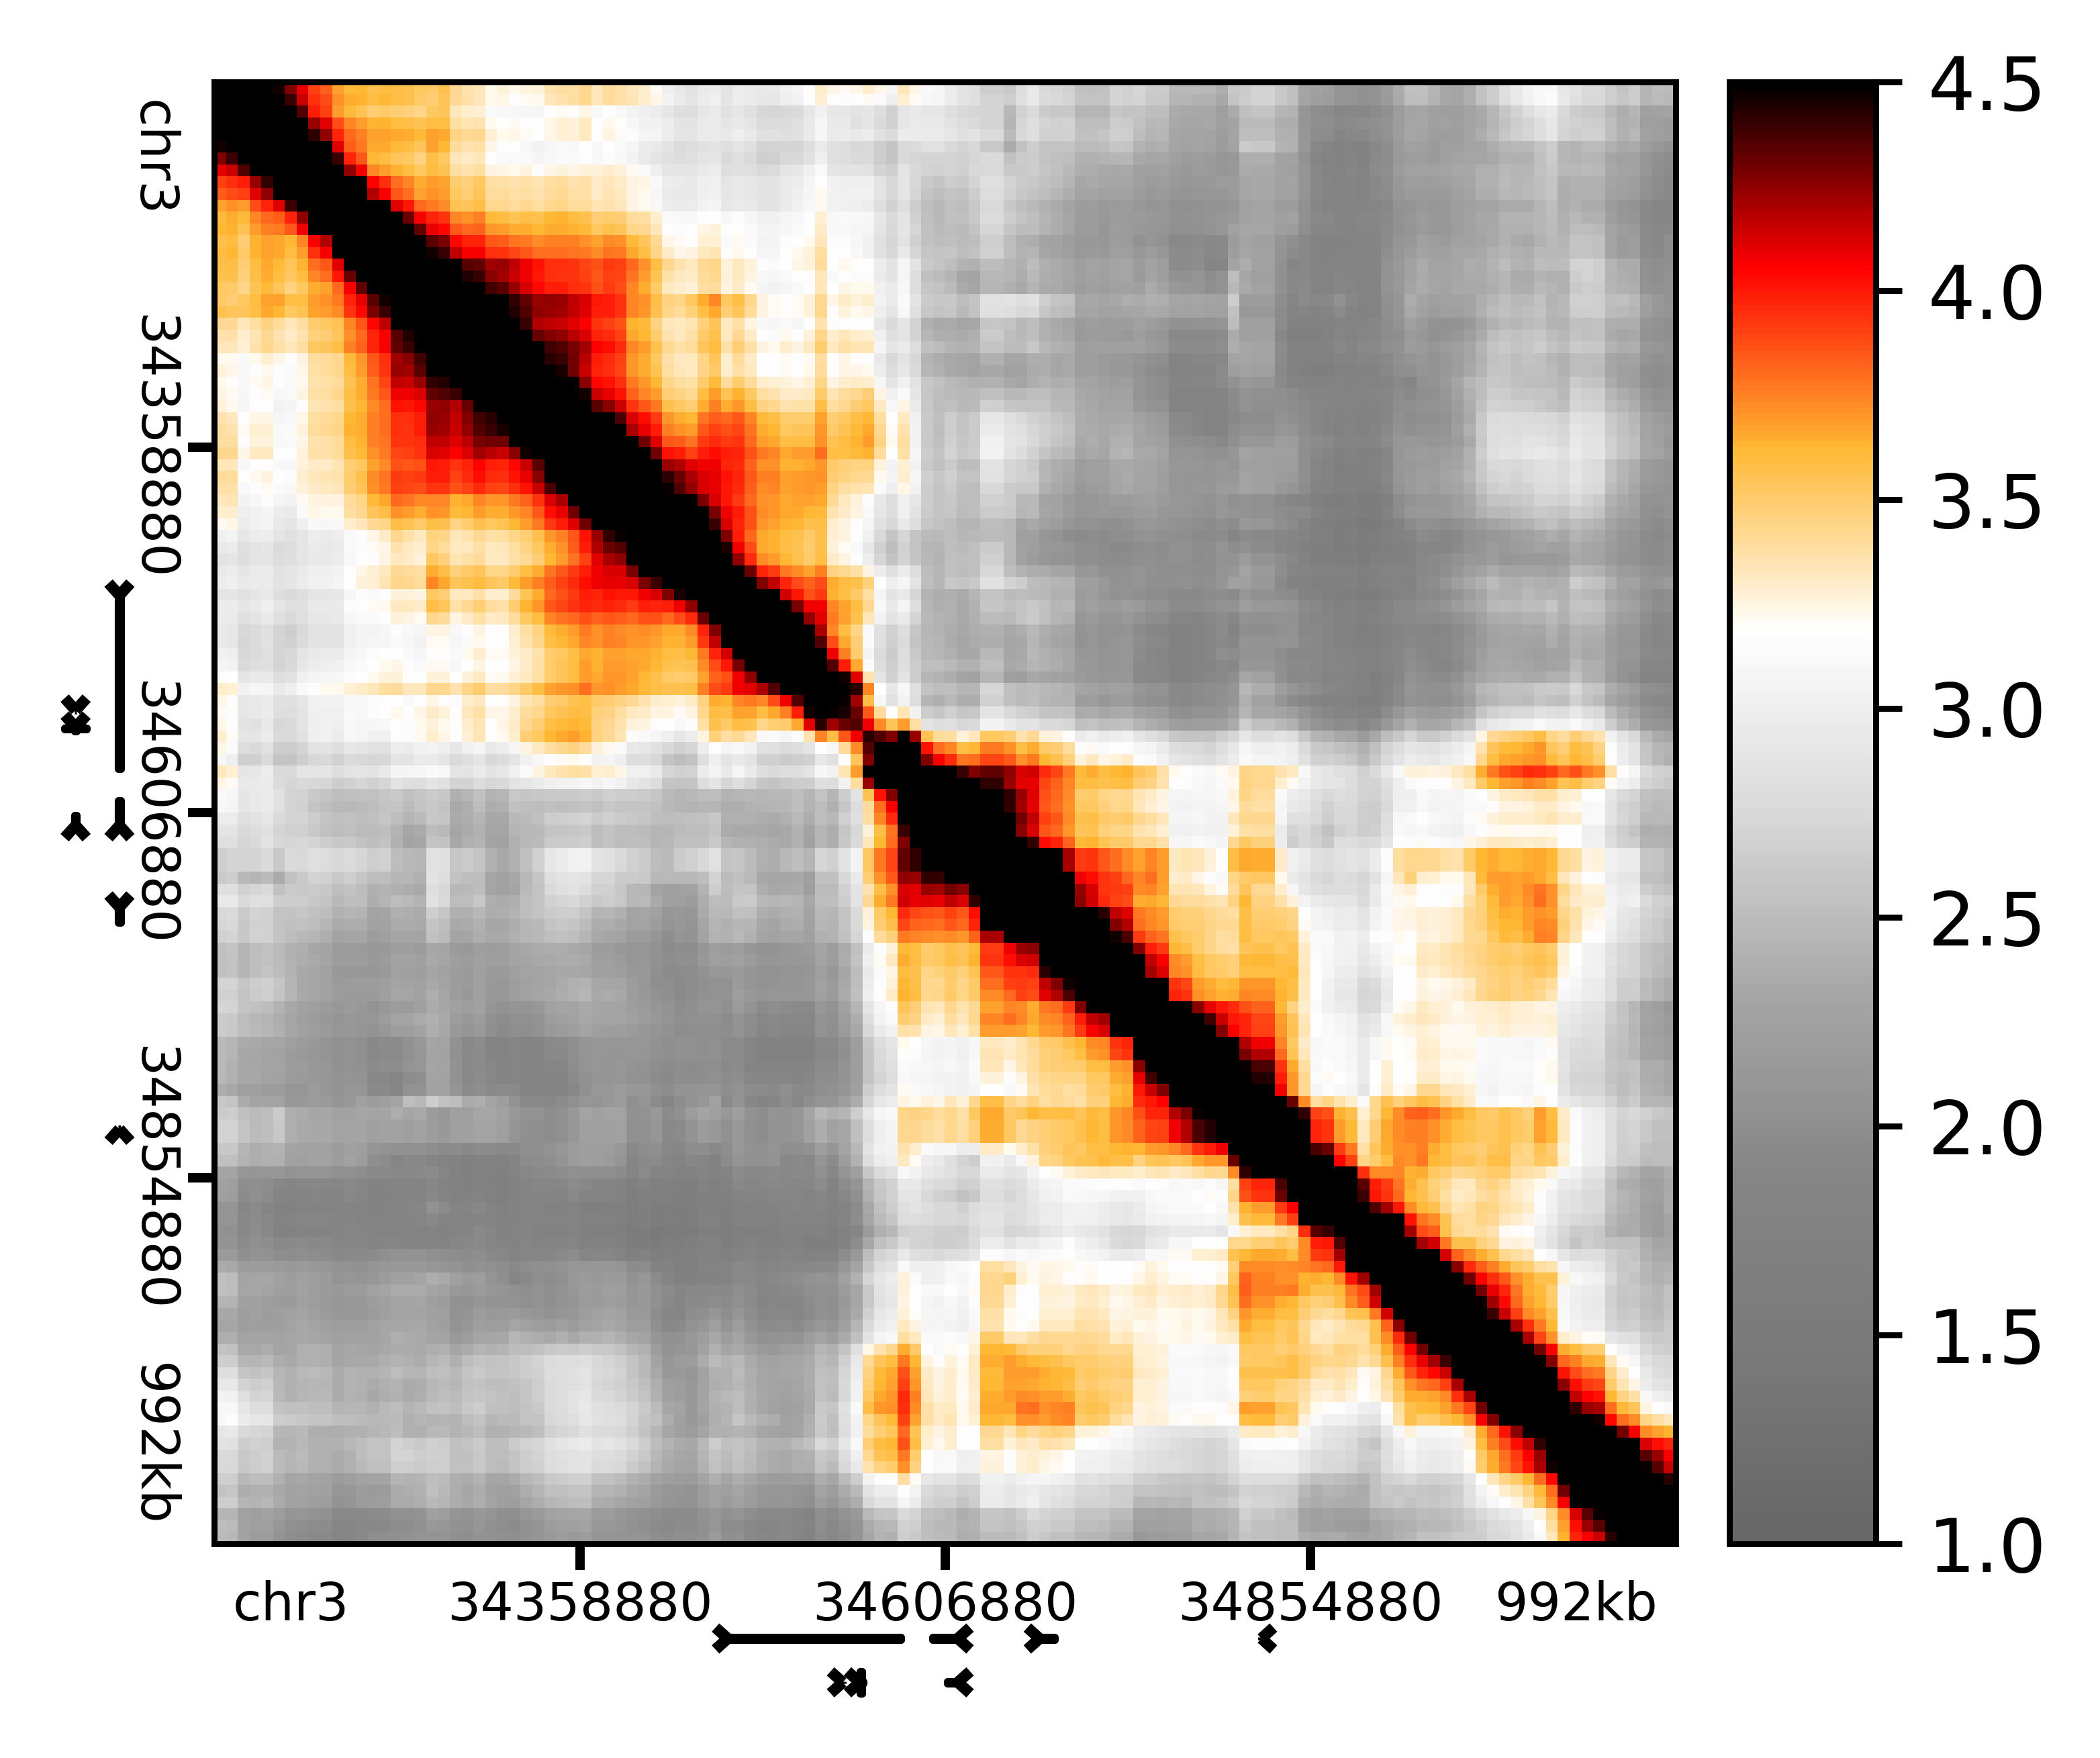

In [25]:
from IPython.display import Image
Image(filename='scripting/pNPC_Rep2_binned_Sox2.png', width=500)

Because [plot_heatmap()](https://lib5c.readthedocs.io/en/latest/lib5c.plotters.heatmap/#lib5c.plotters.heatmap.plot_heatmap) is parallelized with the `@parallelize_regions`
decorator, we can draw the heatmaps for all regions at once by simply calling

In [26]:
%%capture
%matplotlib inline
outfile_names = {region: 'scripting/pNPC_Rep2_binned_%s.png' % region
                 for region in binned_counts.keys()}
plot_heatmap(logged_counts, grange_x=pixelmap, rulers=True, genes='mm9',
             colorscale=(1.0, 4.5), colorbar=True, outfile=outfile_names);

where we precompute a dict of output filenames (parallel to `counts_binned`)
to describe where each region's heatmap will get drawn (since each region will
be drawn to a separate heatmap). In this way, any argument to a parallelized
function can be replaced by a dict whose keys match the keys of the first
positional argument (which is usually a counts dict).

You can show the plot directly inline in a notebook environment by skipping the `outfile` kwarg:

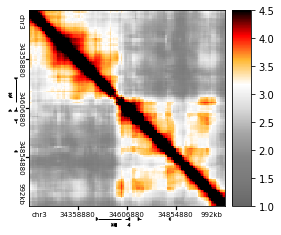

In [27]:
%matplotlib inline
plot_heatmap(logged_counts['Sox2'], grange_x=pixelmap['Sox2'], rulers=True,
             genes='mm9', colorscale=(1.0, 4.5), colorbar=True);

Expected modeling
-----------------

The exposed convenience function for making an expected model is
[lib5c.algorithms.expected.make_expected_matrix()](https://lib5c.readthedocs.io/en/latest/lib5c.algorithms.expected/#lib5c.algorithms.expected.make_expected_matrix).

To construct an expected model for each region using a simple power law
relationship and apply donut correction in the same step, we can try

In [28]:
from lib5c.algorithms.expected import make_expected_matrix
exp_counts, dist_exp, _ = make_expected_matrix(
    binned_counts, regression=True, exclude_near_diagonal=True, donut=True)

using polynomial log-log 1-D distance model


using polynomial log-log 1-D distance model


applying donut correction


applying donut correction


The first returned value, `counts_exp`, is simply a dict of the expected
matrices representing the model. The second returned value, `dist_exp`, is a
representation of the simple one-dimensional expected model.

We can visualize the one-dimensional expected model using
[lib5c.plotters.expected.plot_bin_expected()](https://lib5c.readthedocs.io/en/latest/lib5c.plotters.expected/#lib5c.plotters.expected.plot_bin_expected).

In [29]:
%%capture
%matplotlib inline
from lib5c.plotters.expected import plot_bin_expected
plot_bin_expected(binned_counts['Sox2'], dist_exp['Sox2'],
                  outfile='scripting/pNPC_Rep2_expected_model_Sox2.png',
                  hexbin=True, semilog=True, xlabel='distance');

or for all regions at once,

In [30]:
%%capture
%matplotlib inline
from lib5c.plotters.expected import plot_bin_expected
outfile_names = {region: 'scripting/pNPC_Rep2_expected_model_%s.png' % region
                 for region in binned_counts.keys()}
plot_bin_expected(binned_counts, dist_exp, outfile=outfile_names, hexbin=True,
                  semilog=True, xlabel='distance');

The kwargs `hexbin`, `semilog`, and `ylabel` tweak the visual appearance
of the resulting plot.

The resulting images should look something like this:

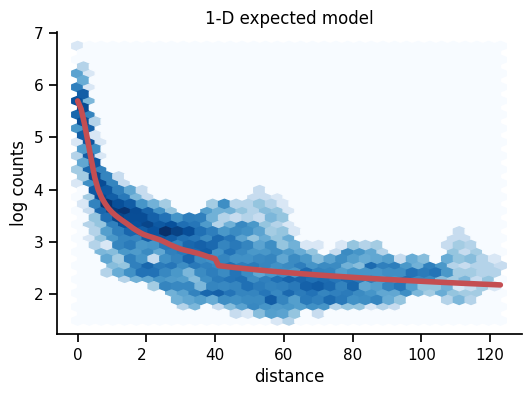

In [31]:
Image(filename='scripting/pNPC_Rep2_expected_model_Sox2.png', width=500)

To learn more, consult the section on [Expected modeling](https://lib5c.readthedocs.io/en/latest/expected_modeling/).

Variance modeling
-----------------

The exposed convenience functions for variance modeling is
[lib5c.algorithms.variance.estimate_variance()](https://lib5c.readthedocs.io/en/latest/lib5c.algorithms.variance.estimate_variance/#lib5c.algorithms.variance.estimate_variance).

We can get variance estimates from a log-normal, deviation-based distance-variance relationship model by trying

In [32]:
from lib5c.algorithms.variance import estimate_variance
var_counts = estimate_variance(binned_counts, exp_counts)

To learn more, consult the section on [Variance modeling](https://lib5c.readthedocs.io/en/latest/variance_modeling/).

P-value calling
---------------

The exposed convenience function for calling p-values using distributions
parametrized according to the expected and variance models is
[lib5c.util.distributions.call_pvalues()](https://lib5c.readthedocs.io/en/latest/lib5c.util.distributions/#lib5c.util.distributions.call_pvalues).

To simply call the p-values using a log-normal distribution, we can try

In [33]:
from lib5c.util.distributions import call_pvalues
from lib5c.util.counts import parallel_log_counts
pvalues = call_pvalues(parallel_log_counts(binned_counts), exp_counts,
                       var_counts, 'norm', log=True)

Where we are logging the observed counts and comparing them to a normal distribution. 

We can visualize these called p-values as interaction scores
(`-10*log2(pvalue)`) on heatmaps by calling

In [34]:
%%capture
%matplotlib inline
from lib5c.plotters.heatmap import plot_heatmap
from lib5c.util.counts import convert_pvalues_to_interaction_scores
outfile_names = {region: 'scripting/pNPC_Rep2_is_%s.png' % region
                 for region in pvalues.keys()}
interaction_scores = convert_pvalues_to_interaction_scores(pvalues)
plot_heatmap(interaction_scores, grange_x=pixelmap, rulers=True, #genes='mm9',
             colorscale=(0, 300), colorbar=True, colormap='is',
             outfile=outfile_names);

and write the called p-values to the disk as counts files by calling

In [35]:
from lib5c.writers.counts import write_counts
write_counts(pvalues, 'scripting/pNPC_Rep2_pvalues.counts', pixelmap)

The resulting heatmaps should look something like this

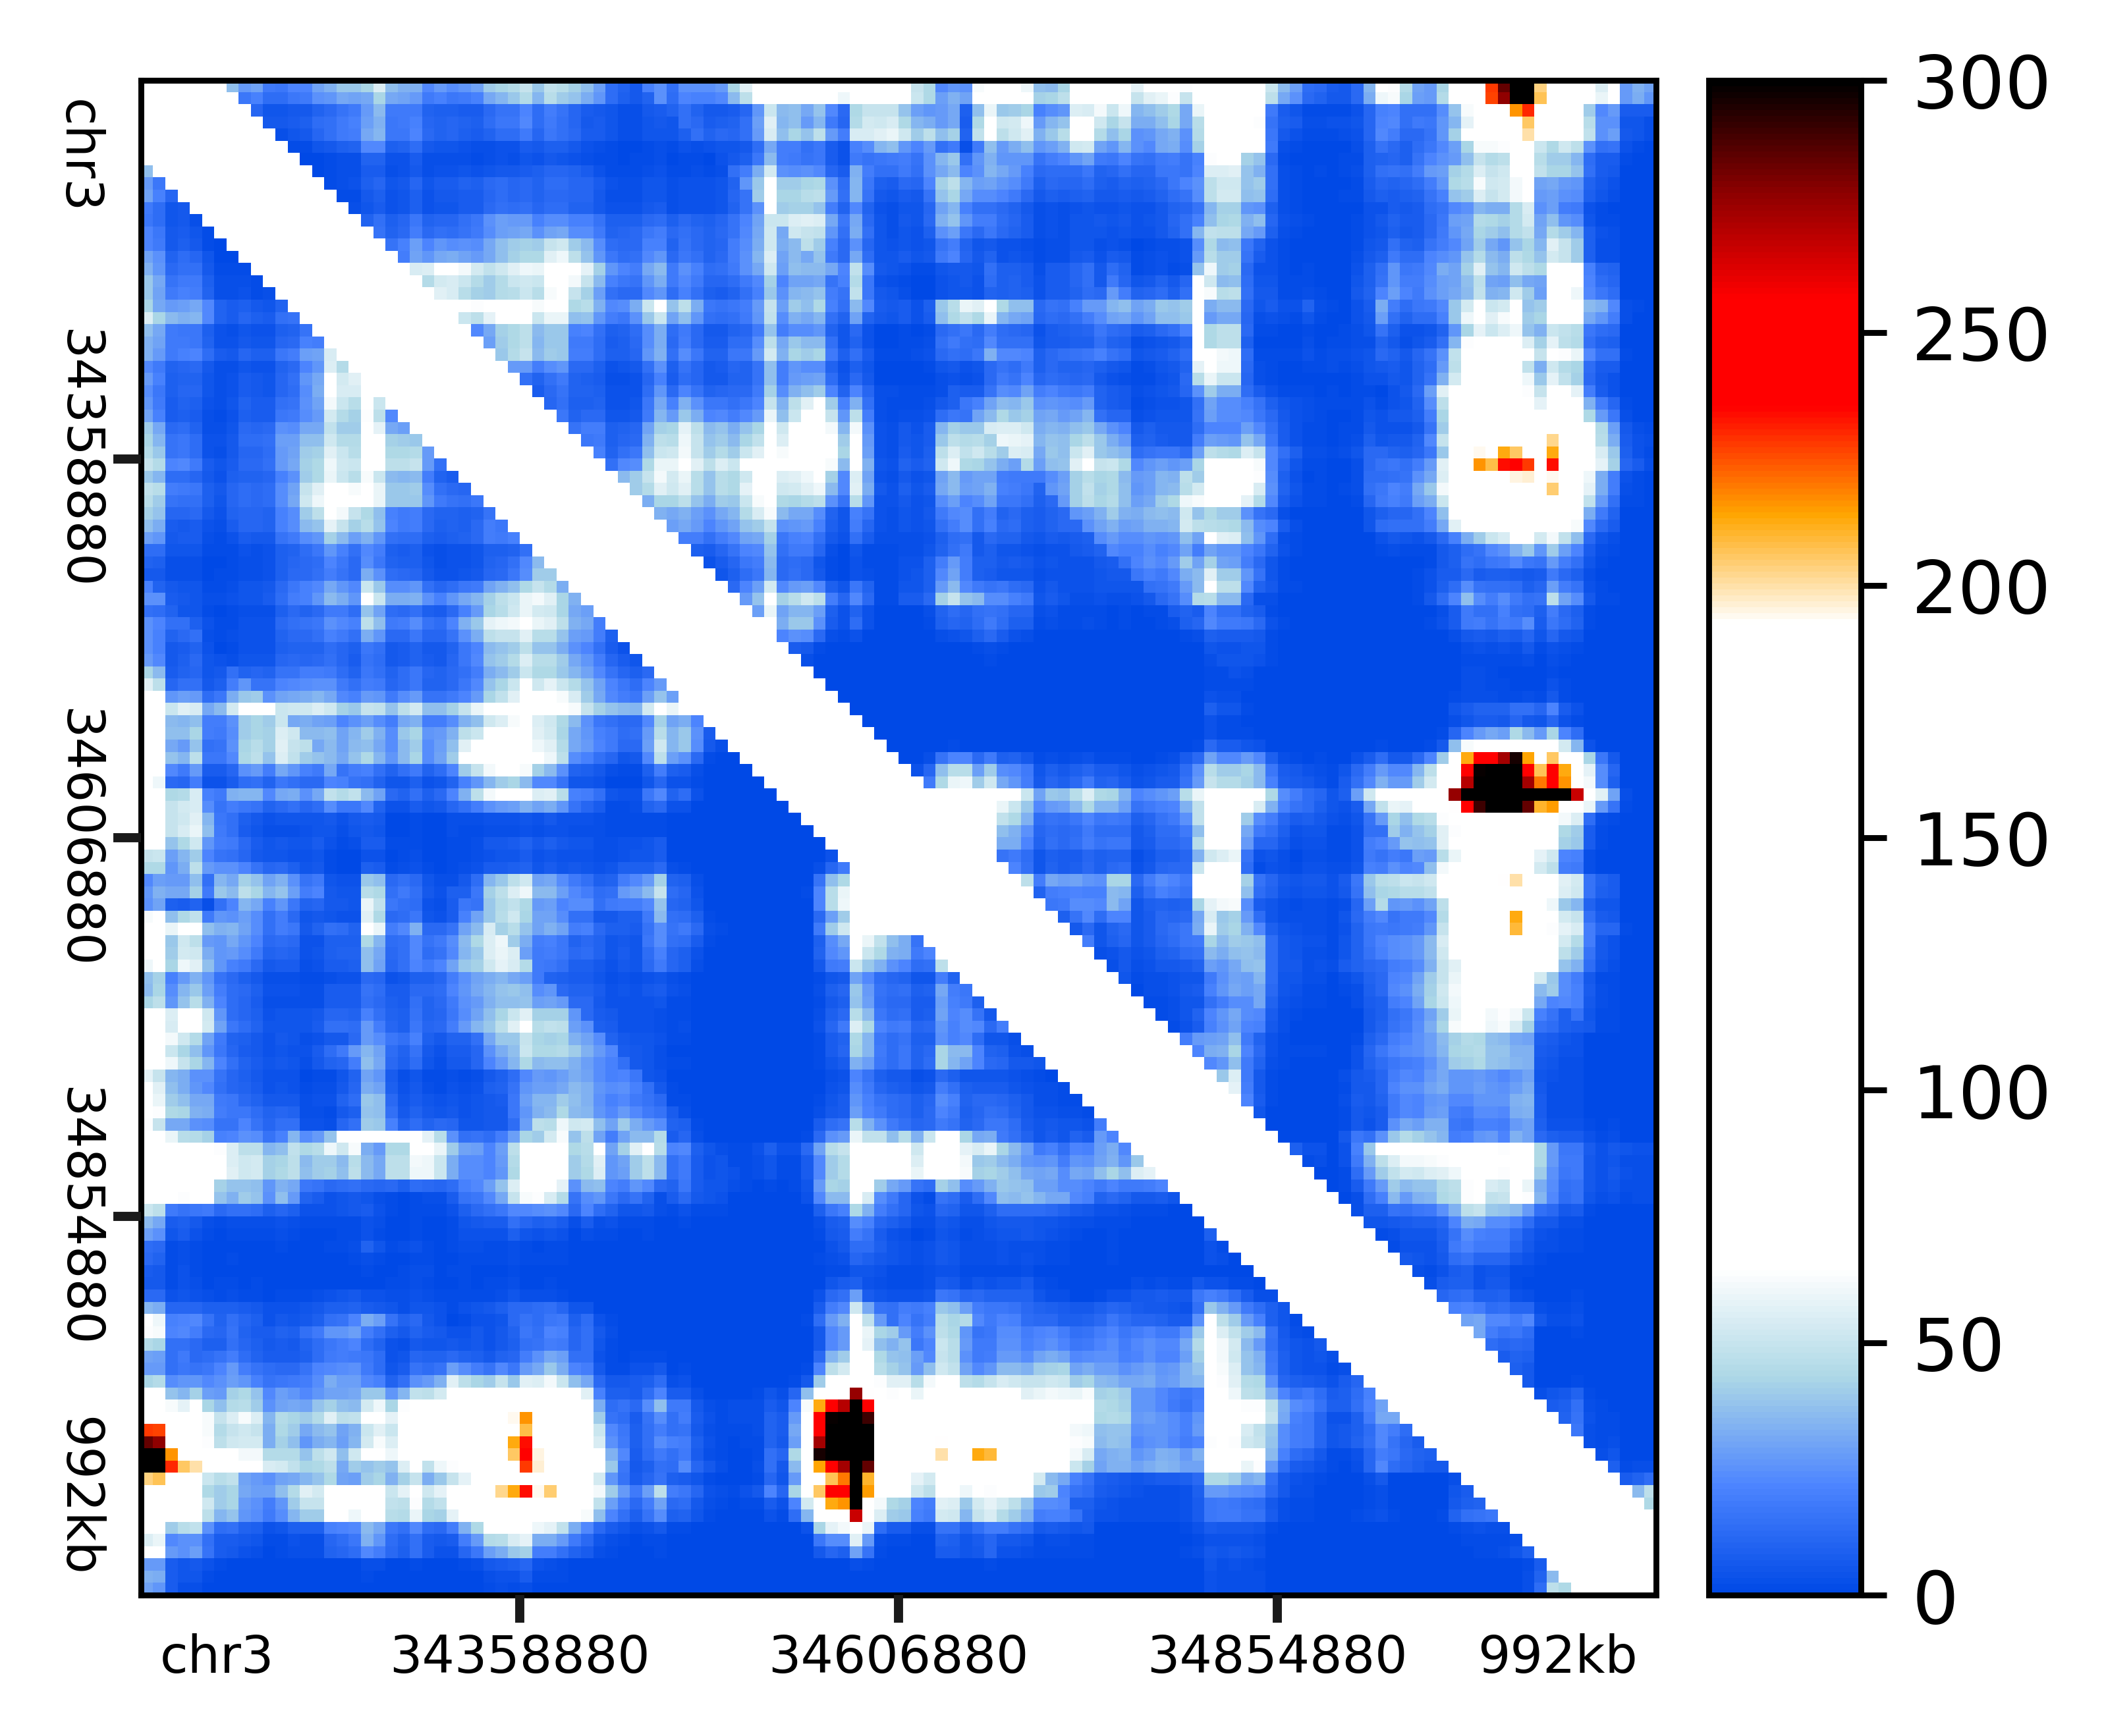

In [36]:
Image(filename='scripting/pNPC_Rep2_is_Sox2.png', width=500)

For more information on the distribution fitting and p-value calling API, see
the section on [Distributions](https://lib5c.readthedocs.io/en/latest/distributions/).

Next steps
----------

This tutorial shows only a few of the functions exposed in the `lib5c` API.
You can read more about what you can do with `lib5c` in the section on
[API specification and conceptual documentation](https://lib5c.readthedocs.io/en/latest/conceptual/).